In [42]:
import torch
import torch.nn as nn
import torch.fx as fx
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [43]:
DATA_ROOT = "../data"
tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.2860], [0.3530])])

In [44]:
train_ds = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=True,
    transform=tx,
    download=True
)
print(len(train_ds))

test_ds = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=False,
    transform=tx,
    download=True
)
print(len(test_ds))

60000
10000


In [45]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [46]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [55]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cv = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.mp = nn.MaxPool2d(2)
        self.ft = nn.Flatten()
        self.l1 = nn.Linear(3136, 128)
        self.relu2 = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        cv = self.cv(x)
        relu1 = self.relu1(cv)
        mp = self.mp(relu1)
        ft = self.ft(mp)
        l1 = self.l1(ft)
        relu2 = self.relu2(l1)
        l2 = self.l2(relu2)
        return l2

net = FashionCNN()
print(net)
test_result = net.forward(images)
print(test_result.shape)

FashionCNN(
  (cv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ft): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=3136, out_features=128, bias=True)
  (relu2): ReLU()
  (l2): Linear(in_features=128, out_features=10, bias=True)
)
torch.Size([64, 10])


In [48]:
model = FashionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [49]:
@torch.no_grad()
def evaluate(model, criterion, loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    for x, y in loader:
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += float(loss.item())
        pred = logits.argmax(dim=1)
        total_correct += int((pred == y).sum().item())
        total_samples += int(y.size(0))
    
    avg_loss = running_loss / len(loader)
    acc = total_correct / max(1, total_samples)
    return {"loss": avg_loss, "acc": acc}

In [50]:
best_acc = -1.0
train_losses, val_losses, val_accs = [], [], []

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    running = 0.0
    for x, y in train_loader:
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += float(loss.item())
    train_loss = running / len(train_loader)

    metrics = evaluate(model, criterion, test_loader)
    val_loss = metrics["loss"]
    val_acc = metrics["acc"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"train={train_loss:.4f}  val={val_loss:.4f}  acc={val_acc*100:5.2f}%")


Epoch 01/10 | train=0.4869  val=0.4080  acc=85.68%
Epoch 02/10 | train=0.3305  val=0.3296  acc=88.15%
Epoch 03/10 | train=0.2924  val=0.3372  acc=87.56%
Epoch 04/10 | train=0.2670  val=0.2918  acc=89.39%
Epoch 05/10 | train=0.2460  val=0.3156  acc=88.75%
Epoch 06/10 | train=0.2328  val=0.2697  acc=90.35%
Epoch 07/10 | train=0.2154  val=0.2875  acc=89.19%
Epoch 08/10 | train=0.2013  val=0.2637  acc=90.53%
Epoch 09/10 | train=0.1889  val=0.2642  acc=90.52%
Epoch 10/10 | train=0.1765  val=0.2526  acc=90.83%


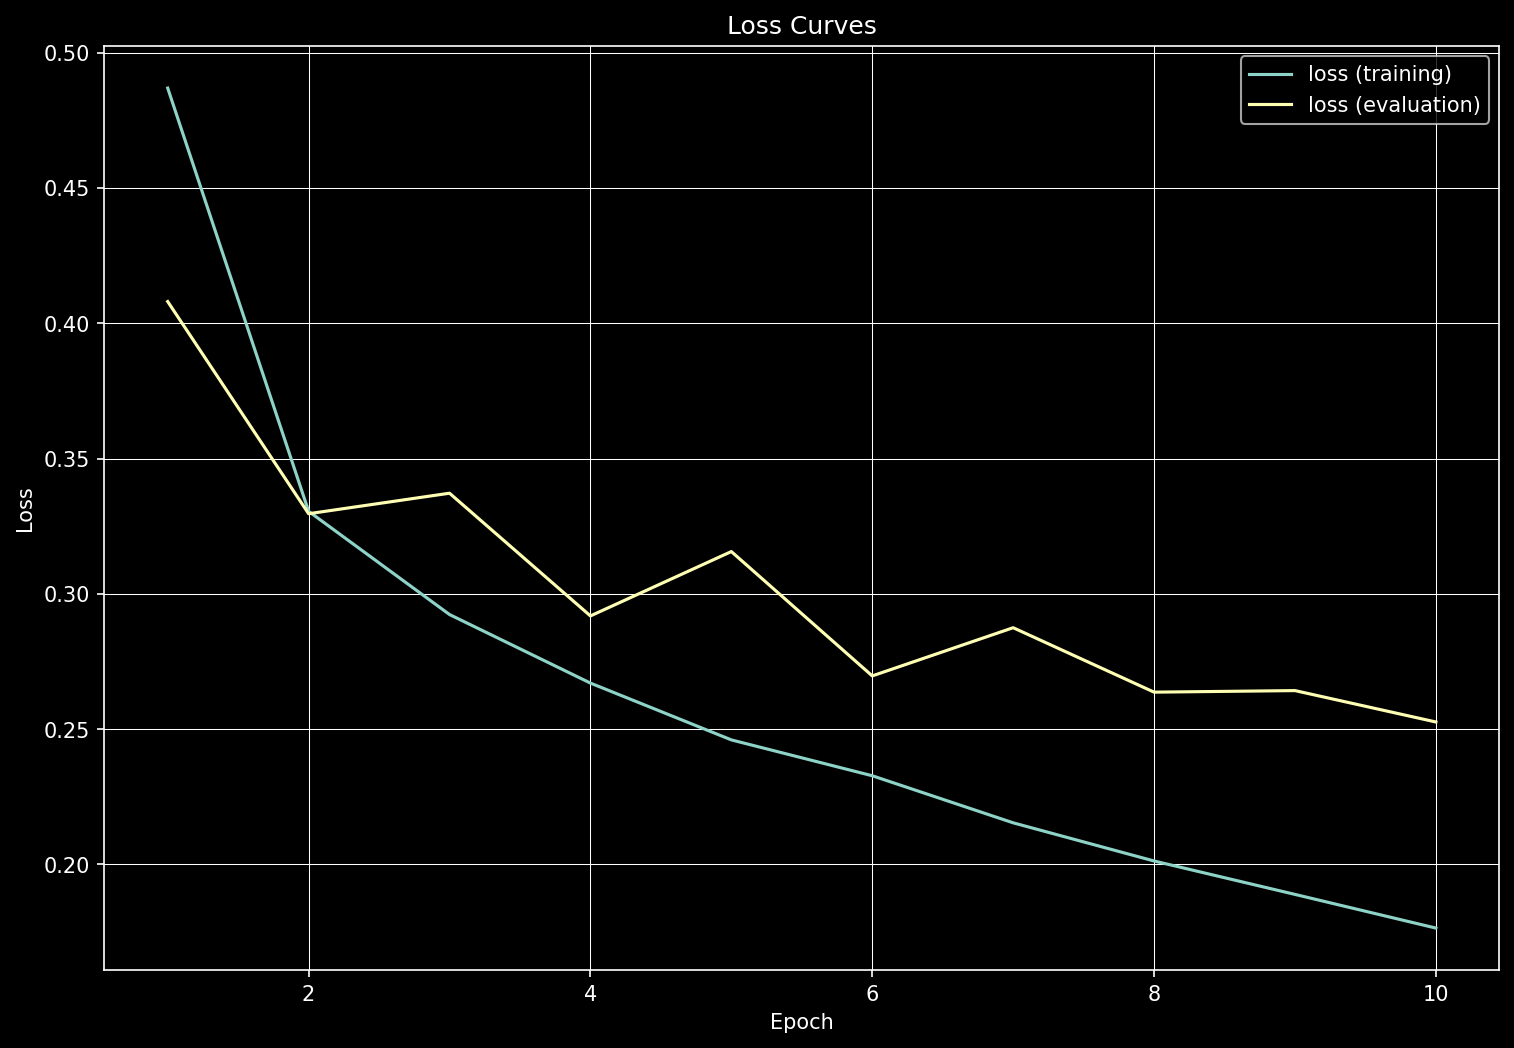

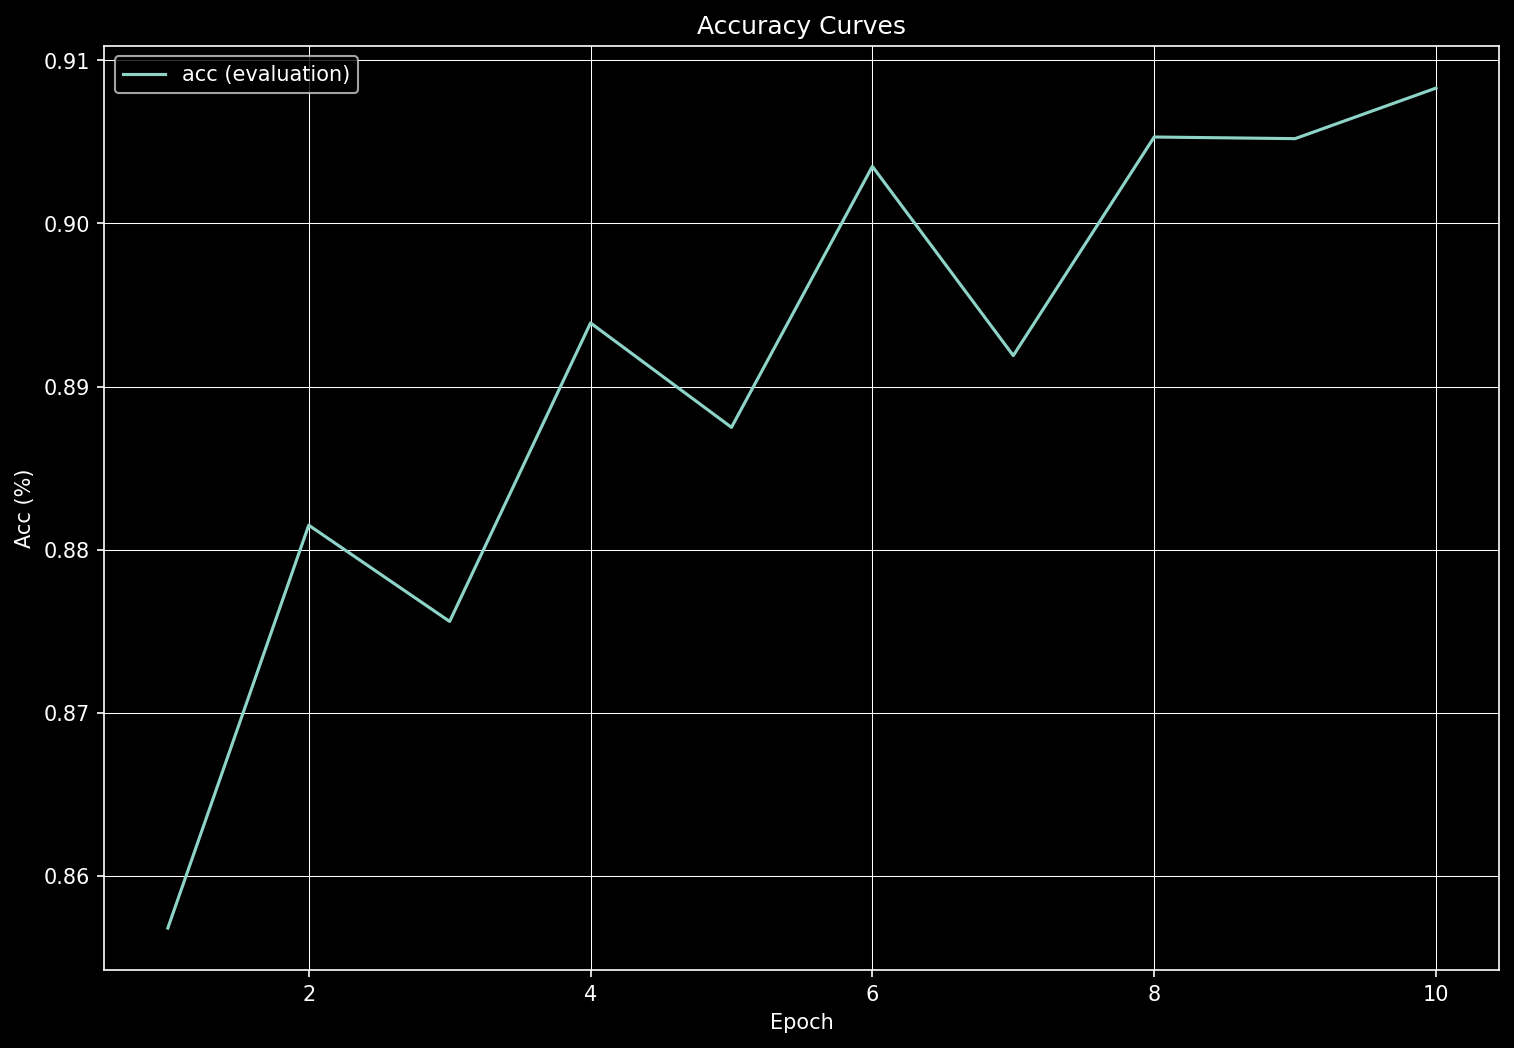

In [51]:
plt.style.use("dark_background")

epoch_x = np.arange(1, 11)
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, train_losses, label='loss (training)')
plt.plot(epoch_x, val_losses, label='loss (evaluation)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.savefig("../results/loss_curve.png")
plt.show()

plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, val_accs, label='acc (evaluation)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Acc (%)")
plt.legend()
plt.title("Accuracy Curves")
plt.savefig("../results/accuracy_curve.png")
plt.show()